# Wstęp

Celem tego projektu jest przeprowadzenie klasyfikacji na wybranej bazie danych z wykorzystaniem podstawowych klasyfikatorów:

- [_K-najbliższych sąsiadów_](https://pl.wikipedia.org/wiki/K_najbli%C5%BCszych_s%C4%85siad%C3%B3w),
- [_naiwny klasyfikator bayesowski_](https://pl.wikipedia.org/wiki/Naiwny_klasyfikator_bayesowski),
- [_drzewo decyzyjne_](https://pl.wikipedia.org/wiki/Drzewo_decyzyjne),
- [_sieć neuronowa_](https://pl.wikipedia.org/wiki/Sie%C4%87_neuronowa).

Wybrana przeze mnie baza danych zawiera informacje o [diamentach](https://www.kaggle.com/datasets/shivam2503/diamonds).
Składa się ona z $53941$ wierszy i następujących $11$ kolumn:

1. **indeks**
2. **ilość karatów** (carat) - wartości od $0.2$ do $5.01$
3. **jakość cięcia** (quality of the cut) - wartości _Fair_, _Good_, _Very Good_, _Premium_, _Ideal_
4. **kolor** (color) - wartości od _J_ (najgorszy) do _D_ (najlepszy)
5. **klarowność** (clarity) - wartości _I1_ (najgorsza), _SI2_, _SI1_, _VS2_, _VS1_, _VVS2_, _VVS1_, _IF_ (najlepsza)
6. **dlugość** (x) - długość w milimetrach, wartości od $0$ do $10.74$
7. **szerokość** (y) - szerokość w milimetrach, wartości od $0$ do $58.9$
8. **głębokość** (z) - głębokość w milimetrach, wartości od $0$ do $31.8$
9. **łączny procent głębokości** (depth) - wyliczony ze wzoru $2z/(x + y)$, wartości od $43$ do $79$
10. **szerokość szczytu diamentu względem jego najszerszego punktu** (table) - wartości od $43$ do $95$
11. **cena** (price) - cena diamentu w dolarach, od $\$326$ do $\$18,823$

W mojej pracy będę starał się przewidzieć przedział ceny diamentu na podstawie jego pozostałych właściwości.

# Przygotowanie danych

W celu przeprowadzenia klasyfikacji przygotuje $2$ bazy o różnym stopniu modyfikacji i przygotowania danych.
Wykorzystane do tego zostaną następujące biblioteki:

- [_Pandas_](https://pandas.pydata.org/)
- [_NumPy_](https://numpy.org/)
- [_scikit-learn_](https://scikit-learn.org/stable/)
- [_SciPy_](https://scipy.org/)

W poniższym fragmencie kodu zostają one zaimportowane, wczytany jest także plik [`diamonds.csv`](diamonds.csv) zawierający dane.
Poniżej jest także wyświetlona krótka charakterystyka danych:


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import zscore

diamonds = pd.read_csv("diamonds.csv", index_col=0)

diamonds.describe()


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Przygotowanie pierwszej bazy danych

Pierwsza baza danych zostanie mniej przetworzona niż druga i ulegnie jedynie podstawowym modyfikacjom.

### Zamiana wartości tekstowych na liczby

Pierwszym krokiem będzie zamiana wartości tekstowych na liczbowe, ponieważ wybrane algorytmy klasyfikujące nie są w stanie działać na danych tekstowych.
W wybranej bazie znajdują się $3$ kolumny z wartościami tekstowymi: _jakość cięcia_ (cut), _kolor_ (color) oraz _klarowność_ (clarity).
Wartości zostaną zmienione w następujący sposób:

<table><thead><tr><th colspan="2">Jakość cięcia</th><th colspan="2">Kolor<br></th><th colspan="2">Klarowność</th></tr></thead><tbody><tr><td>Przed zmianą</td><td>Po zmianie</td><td>Przed zmianą</td><td>Po zmianie<br></td><td>Przed zmianą</td><td>Po zmianie</td></tr><tr><td>Fair<br></td><td>0</td><td>D</td><td>0</td><td>I1</td><td>0</td></tr><tr><td>Good</td><td>1</td><td>E</td><td>1</td><td>SI2</td><td>1</td></tr><tr><td>Very Good</td><td>2</td><td>F</td><td>2</td><td>SI1</td><td>2</td></tr><tr><td>Premium</td><td>3</td><td>G</td><td>3</td><td>VS2</td><td>3</td></tr><tr><td>Ideal</td><td>4</td><td>H</td><td>4</td><td>VS1</td><td>4</td></tr><tr><td colspan="2" rowspan="3"></td><td>I</td><td>5</td><td>VVS2</td><td>5</td></tr><tr><td>J</td><td>6</td><td>VVS1</td><td>6</td></tr><tr><td colspan="2"></td><td>IF</td><td>7</td></tr></tbody></table>

Do przetworzenia $2$ pierwszych kolumn można wykorzystać obiekt klasy `LabelEncoder` dostępnej w bibliotece `sklearn`, natomiast do modyfikacji klarowności posłuży specjalnie zdefiniowana funkcja `transform_clarity`:


In [2]:
def transform_clarity(value):
    res = 0
    match value:
        case "I1": res = 0
        case "SI2": res = 1
        case "SI1": res = 2
        case "VS2": res = 3
        case "VS1": res = 4
        case "VVS2": res = 5
        case "VVS1": res = 6
        case "IF": res = 7
        case _: res = value

    return res


LE = LabelEncoder()

first_database = diamonds.copy()

first_database.sort_values(by="cut", inplace=True)
first_database["cut"] = LE.fit_transform(first_database["cut"])

first_database.sort_values(by="color", inplace=True)
first_database["color"] = LE.fit_transform(first_database["color"])

first_database["clarity"] = first_database["clarity"].apply(transform_clarity)


Po zmianie dane prezentują się w następujący sposób:


In [3]:
first_database.describe()


,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,2.553003,2.594197,3.051020,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.027708,1.701105,1.647136,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,2.000000,1.000000,2.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,2.000000,3.000000,3.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,3.000000,4.000000,4.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Usunięcie niepoprawnych danych

Drugim krokiem w przygotowaniu pierwszej bazy jest usunięcie niepoprawnych danych.
W tym przypadku są to wiersze zawierające wartości $x$, $y$ lub $z$ równe $0$ - te dane opisują diamenty, które nie mają zdefiniowanego przynajmniej jednego ze swoich wymiarów, wobec tego nie mogą występować w przyrodzie.


In [4]:
first_database = first_database[first_database["x"] != 0]
first_database = first_database[first_database["y"] != 0]
first_database = first_database[first_database["z"] != 0]


Usunęliśmy w ten sposób $20$ niepoprawnych wierszy.
Poniżej widoczny jest wynik zmian:


In [5]:
first_database.describe()


,carat,cut,color,clarity,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,2.553079,2.594028,3.051502,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.027705,1.701272,1.647005,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,2.000000,1.000000,2.000000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,2.000000,3.000000,3.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,3.000000,4.000000,4.000000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Zamiana unikalnych cen diamentów na przedziały

Ponieważ ceny diamentów bardzo się od siebie różnią, aby ułatwić proces nauki szukaną wartością w klasyfikacji zamiast dokładnej ceny będzie przedział, w którym się ona znajduje.
Poniższy fragment kodu pozwoli wyznaczyć odpowiednie przedziały:


In [6]:
prices = first_database["price"].values
prices.sort()

splitted_prices = np.array_split(prices, 8)

for arr in splitted_prices:
    print("Min: {} - Max: {}".format(min(arr), max(arr)))


Min: 326 - Max: 694
Min: 694 - Max: 949
Min: 949 - Max: 1571
Min: 1571 - Max: 2401
Min: 2401 - Max: 3795
Min: 3795 - Max: 5323
Min: 5324 - Max: 8681
Min: 8683 - Max: 18823


Stworzone zostaną więc następujące przedziały:

<table><thead><tr><th colspan="2">Przedział cen</th><th rowspan="2">Numer przedziału</th></tr><tr><th>Od</th><th>Do</th></tr></thead><tbody><tr><td>$326</td><td>$695</td><td>0</td></tr><tr><td>$695</td><td>$950</td><td>1</td></tr><tr><td>$950</td><td>$1570</td><td>2</td></tr><tr><td>$1570</td><td>$2400</td><td>3</td></tr><tr><td>$2400</td><td>$3795</td><td>4</td></tr><tr><td>$3795</td><td>$5325</td><td>5</td></tr><tr><td>$5325</td><td>$8680</td><td>6</td></tr><tr><td>$8680</td><td>$18823</td><td>7</td></tr></tbody></table>

Wartości cen zostały dobrane tak, by każdy przedział miał możliwie tyle samo elementów.


In [7]:
def transform_price(value):
    if value < 695:
        return 0
    elif 695 <= value < 950:
        return 1
    elif 950 <= value < 1570:
        return 2
    elif 1570 <= value < 2400:
        return 3
    elif 2400 <= value < 3795:
        return 4
    elif 3795 <= value < 5325:
        return 5
    elif 5325 <= value < 8680:
        return 6
    elif 8680 <= value:
        return 7
    else:
        return value


first_database["price"] = first_database["price"].apply(transform_price)


Poniżej znajduje się przygotowana pierwsza baza danych:


In [8]:
first_database.describe()


,carat,cut,color,clarity,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,2.553079,2.594028,3.051502,61.749514,57.456834,3.500000,5.731627,5.734887,3.540046
std,0.473795,1.027705,1.701272,1.647005,1.432331,2.234064,2.291948,1.119423,1.140126,0.702530
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,0.000000,3.730000,3.680000,1.070000
25%,0.400000,2.000000,1.000000,2.000000,61.000000,56.000000,1.000000,4.710000,4.720000,2.910000
50%,0.700000,2.000000,3.000000,3.000000,61.800000,57.000000,4.000000,5.700000,5.710000,3.530000
75%,1.040000,3.000000,4.000000,4.000000,62.500000,59.000000,5.000000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,7.000000,10.740000,58.900000,31.800000


## Przygotowanie drugiej bazy danych

Pierwsze trzy etapy przygotowania danych są identycznie dla obu baz, wobec tego można skopiować zawartość pierwszej z nich w celu dalszej modyfikacji:


In [9]:
second_database = first_database.copy()


### Usunięcie danych odstających

Etap ten polega na usunięciu danych, które odstają od średnich wartości.
W tym celu wykorzystamy tzw. [z-score](https://en.wikipedia.org/wiki/Standard_score) (standardowy wynik), czyli stopień odchylenia wartości od średniej.
Usunięte zostaną dane, dla których $|z-score| < 3$.


In [10]:
z_score = np.abs(zscore(second_database))

second_database = second_database[(z_score < 3).all(axis=1)]


W ten sposób usunięte zostało $1368$ skrajnych wierszy. Po tym etapie druga baza danych wygląda następująco:


In [11]:
second_database.describe()


,carat,cut,color,clarity,depth,table,price,x,y,z
count,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000
mean,0.780895,2.592461,2.573908,3.079673,61.747498,57.381112,3.475700,5.699652,5.702963,3.520008
std,0.449400,0.989303,1.693015,1.641637,1.272021,2.102460,2.289237,1.092696,1.085779,0.673896
min,0.200000,0.000000,0.000000,0.000000,57.500000,51.000000,0.000000,3.730000,3.680000,1.530000
25%,0.400000,2.000000,1.000000,2.000000,61.100000,56.000000,1.000000,4.700000,4.710000,2.900000
50%,0.700000,2.000000,3.000000,3.000000,61.800000,57.000000,3.000000,5.680000,5.690000,3.510000
75%,1.040000,3.000000,4.000000,4.000000,62.500000,59.000000,5.000000,6.520000,6.520000,4.030000
max,2.210000,4.000000,6.000000,7.000000,66.000000,64.000000,7.000000,8.630000,8.560000,5.300000


### Normalizacja

Ostatnim krokiem przygotowania drugiej bazy jest znormalizowanie danych i przeskalowanie ich tak, aby wartości mieściły się w zakresie $[0, 1]$.
Kolumny, które nie zostaną przeskalowane to: _jakość cięcia_ (cut), _kolor_ (color), _klarowność_ (clarity) oraz _cena_ (price).


In [12]:
columns_to_normalize = ["carat", "depth", "table", "x", "y", "z"]
scaler = MinMaxScaler()

values = second_database[columns_to_normalize].values
scaled_values = scaler.fit_transform(values)

second_database[columns_to_normalize] = pd.DataFrame(
    scaled_values, columns=columns_to_normalize, index=second_database.index)


Po ostatecznym zmodyfikowaniu danych druga baza ma poniższą postać:


In [13]:
second_database.describe()


,carat,cut,color,clarity,depth,table,price,x,y,z
count,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000,52552.000000
mean,0.289002,2.592461,2.573908,3.079673,0.499706,0.490855,3.475700,0.401970,0.414542,0.527854
std,0.223582,0.989303,1.693015,1.641637,0.149650,0.161728,2.289237,0.222999,0.222496,0.178752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.099502,2.000000,1.000000,2.000000,0.423529,0.384615,1.000000,0.197959,0.211066,0.363395
50%,0.248756,2.000000,3.000000,3.000000,0.505882,0.461538,3.000000,0.397959,0.411885,0.525199
75%,0.417910,3.000000,4.000000,4.000000,0.588235,0.615385,5.000000,0.569388,0.581967,0.663130
max,1.000000,4.000000,6.000000,7.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000


# Przeprowadzenie klasyfikacji

Następnym etapem po przygotowaniu danych będzie przeprowadzenie klasyfikacji na obu bazach z wykorzystaniem różnych algorytmów.
Przed przystąpieniem do tego etapu należy podzielić bazy na zbiory treningowe oraz testowe.
Dane zostaną podzielone w proporcjach $70:30$.
W tym celu wykorzystam funkcję `train_test_split` z biblioteki `sklearn`:


In [14]:
from sklearn.model_selection import train_test_split

first_db_train_set, first_db_test_set = train_test_split(
    first_database.values, train_size=0.7, random_state=1)

second_db_train_set, second_db_test_set = train_test_split(
    second_database.values, train_size=0.7, random_state=1)


Ostatnim krokiem przed przystąpieniem do klasyfikacji jest oddzielenie danych wyjściowych (ang. classes, w tym przypadku przedziałów cen diamentów) od danych wejściowych (ang. inputs, czyli pozostałych kolumn):


In [15]:
first_db_train_inputs = np.delete(first_db_train_set, obj=6, axis=1)
first_db_train_classes = first_db_train_set[:, 6]

first_db_test_inputs = np.delete(first_db_test_set, obj=6, axis=1)
first_db_test_classes = first_db_test_set[:, 6]

second_db_train_inputs = np.delete(second_db_train_set, obj=6, axis=1)
second_db_train_classes = second_db_train_set[:, 6]

second_db_test_inputs = np.delete(second_db_test_set, obj=6, axis=1)
second_db_test_classes = second_db_test_set[:, 6]


Poniżej zdefiniowana jest także funkcja pomocnicza `display_model_statistics`, która posłuży do wyświetlenia procentu dokładności oraz macierzy błędu danego modelu wytrenowanego na obu bazach danych:


In [16]:
from IPython.display import HTML, display
from sklearn.metrics import confusion_matrix


def display_model_statistics(model1, model2):
    first_score = model1.score(first_db_test_inputs, first_db_test_classes)
    second_score = model2.score(second_db_test_inputs, second_db_test_classes)

    first_prediction = model1.predict(first_db_test_inputs)
    first_cm = pd.DataFrame(confusion_matrix(
        first_db_test_classes, first_prediction))

    second_prediction = model2.predict(second_db_test_inputs)
    second_cm = pd.DataFrame(confusion_matrix(
        second_db_test_classes, second_prediction))

    print("First database acuraccy: {:.3f}%\t\t\tSecond database acuraccy: {:.3f}%".format(
        first_score * 100, second_score * 100))
    print("First database confusion matrix:\t\t\tSecond database confusion matrix:")
    html = '<div style="display:flex"><div style="margin-right: 2em">{}</div><div style="margin-right: 2em">{}</div></div>'.format(
        first_cm.to_html(), second_cm.to_html())
    display(HTML(html))


## Drzewo decyzyjne

Drzewa decyzyjne w uczeniu maszynowym służą do znajdywania szukanej informacji na podstawie zebranych danych poprzez podejmowanie decyzji.
Algorytm decyduje, np. poprzez porównania wielkości dwóch liczb, która z dwóch gałęzi prowadzi do lepszego rozwiązania.
Do stworzenia drzew decyzyjnych wykorzystam klasę `DecisionTreeClassifier` z biblioteki `sklearn`:


In [17]:
from sklearn.tree import DecisionTreeClassifier


### Pierwszy model

Pierwszym modelem będzie drzewo decyzyjne o nieograniczonej z góry wielkości. W poniższym fragmencie kodu:

- nowa instancja klasyfikatora jest tworzona i uczona na pierwszej bazie danych:


In [18]:
first_big_dtc = DecisionTreeClassifier()
first_big_dtc.fit(first_db_train_inputs, first_db_train_classes);


- tworzona jest następna instancja klasyfikatora, tym razem uczona na drugiej bazie danych:


In [19]:
second_big_dtc = DecisionTreeClassifier()
second_big_dtc.fit(second_db_train_inputs, second_db_train_classes);


- wyświetlone są wyniki obu nauczonych klasyfikatorów - procent dokładności oraz macierz błędu:


In [20]:
display_model_statistics(first_big_dtc, second_big_dtc)


First database acuraccy: 79.000%			Second database acuraccy: 79.056%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2103,0,0,0,0,0,0,0
1,4,1699,333,0,0,0,0,0
2,0,376,1338,311,0,0,0,0
3,0,0,322,1433,155,21,0,0
4,0,0,0,155,1596,261,0,0
5,0,0,0,21,239,1451,291,0
6,0,0,0,0,0,314,1403,280
7,0,0,0,0,0,0,314,1756
,0,1,2,3,4,5,6,7
0,2065,2,0,0,0,0,0,0


Jak widać wyniki dla obu zestawów danych są dla siebie bardzo zbliżone (dokładność w okolicach $79\%$).


### Drugi model


Tworząc drugi model drzewa decyzyjnego, ograniczona zostanie jego wielkość.
Ustawienie parametru `max_depth` na $8$ sprawi, że drzewo będzie mogło mieć maksymalną głębokość wynoszącą $8$ rzędów liści:


In [21]:
small_dtc_params = {
    "max_depth": 8
}


Podobnie jak wyżej, w poniższych fragmentach kodu:

- pierwsze drzewo jest tworzone i uczone na pierwszym zestawie danych:


In [22]:
first_small_dtc = DecisionTreeClassifier(**small_dtc_params)
first_small_dtc.fit(first_db_train_inputs, first_db_train_classes);


- drugie drzewo jest tworzone i uczone na drugiej bazie danych:


In [23]:
second_small_dtc = DecisionTreeClassifier(**small_dtc_params)
second_small_dtc.fit(second_db_train_inputs, second_db_train_classes);


- wyświetlone zostaje porównanie wyników drzew dla obu zestawów danych:


In [24]:
display_model_statistics(first_small_dtc, second_small_dtc)


First database acuraccy: 78.400%			Second database acuraccy: 78.301%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2103,0,0,0,0,0,0,0
1,4,1788,244,0,0,0,0,0
2,0,478,1286,261,0,0,0,0
3,0,0,404,1289,194,44,0,0
4,0,0,0,5,1544,463,0,0
5,0,0,0,0,310,1172,520,0
6,0,0,0,0,0,128,1448,421
7,0,0,0,0,0,0,18,2052
,0,1,2,3,4,5,6,7
0,2066,1,0,0,0,0,0,0


W tym przypadku wyniki są nieznacznie gorsze niż dla pierwszego modelu i również są prawie identyczne dla obu baz danych ($78\%$ dokładności).


## Naiwny klasyfikator bayesowski


Naiwny klasyfikator bayesowski opiera swoje działanie na szacowaniu prawodpodobieństwa przypisania danych wejściowych do danej klasy.
W tym przypadku klasyfikacja polega na obserwowaniu częstości warunkowych opartych na atrybutach wejściowych, a następnie przekształcaniu ich z wykorzystaniem wzoru Bayesa.
Do przeprowadzenia klasyfikacji skorzystam z klasy `GaussianNB` z biblioteki `sklearn`:


In [25]:
from sklearn.naive_bayes import GaussianNB


W celu przeprowadzenia klasyfikacji najpierw tworzę pierwszą instancję klasyfikatora i uczę ją na pierwszej bazie danych:


In [26]:
first_nb = GaussianNB()
first_nb.fit(first_db_train_inputs, first_db_train_classes);


Następnie tworzę drugi model i uczę go na drugim zestawie danych:


In [27]:
second_nb = GaussianNB()
second_nb.fit(second_db_train_inputs, second_db_train_classes);


Poniżej zostają wyświetlone wyniki dla obu wytrenowanych modeli:


In [28]:
display_model_statistics(first_nb, second_nb)


First database acuraccy: 69.838%			Second database acuraccy: 69.891%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2102,0,1,0,0,0,0,0
1,4,1955,76,0,0,0,1,0
2,0,802,556,667,0,0,0,0
3,0,0,310,1382,239,0,0,0
4,0,0,0,0,2012,0,0,0
5,0,0,0,0,1096,431,465,10
6,0,0,0,0,0,623,1023,351
7,0,0,0,0,0,0,234,1836
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


Jak widać w tym przypadku również wyniki są do siebie mocno zbliżone i dla obu baz danych dokładność wynosi około $69.9\%$.


## K-najbliższych sąsiadów


Algorytm K-najbliższych sąsiadów polega na szacowaniu klasy dla danego zestawu danych na podstawie K sąsiadujących znanych wcześniej danych.
Wszystkie dane są reprezentowane jako punkty w przestrzeni (w tym przypadku w przestrzeni $9$ wymiarowej), a w celu zdefiniowania najbliższych sąsiadów obliczana jest odległość między punktami za pomocą ustalonej metryki - dla poniższych modeli wybrałem metrykę euklidesową.
W celu przeprowadzenia klasyfikacji skorzystam z klasy `KNeigborsClassifier` z biblioteki `sklearn`:


In [29]:
from sklearn.neighbors import KNeighborsClassifier


Klasyfikacje przeprowadzę dla 3 różnych ilości sąsiadów: $10$, $20$ i $30$.


### $10$ sąsiadów


Poniżej tworzone i trenowane na obu bazach danych są modele dla $10$ sąsiadów:


In [30]:
first_10nn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
first_10nn.fit(first_db_train_inputs, first_db_train_classes);


In [31]:
second_10nn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
second_10nn.fit(second_db_train_inputs, second_db_train_classes);


Następnie zostają wyświetlone ich statystyki:


In [32]:
display_model_statistics(first_10nn, second_10nn)


First database acuraccy: 77.219%			Second database acuraccy: 80.325%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2074,12,15,2,0,0,0,0
1,17,1752,244,22,0,0,1,0
2,19,474,1297,225,10,0,0,0
3,0,6,423,1270,189,42,1,0
4,0,0,1,83,1650,276,2,0
5,0,0,1,15,362,1308,311,5
6,0,0,0,0,33,319,1332,313
7,0,0,0,1,1,13,247,1808
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


Dla obu zestawów danych wyniki są dobre, jednak dla bardziej przetworzonych danych wynik jest odrobinę lepszy.


### 20 sąsiadów


Poniżej tworzone i uczone są modele dla $20$ sąsiadów:


In [33]:
first_20nn = KNeighborsClassifier(n_neighbors=20, metric='euclidean')
first_20nn.fit(first_db_train_inputs, first_db_train_classes);


In [34]:
second_20nn = KNeighborsClassifier(n_neighbors=20, metric='euclidean')
second_20nn.fit(second_db_train_inputs, second_db_train_classes);


Następnie wyświetlone zostają ich dokładności oraz macierze błędu:


In [35]:
display_model_statistics(first_20nn, second_20nn)


First database acuraccy: 77.127%			Second database acuraccy: 80.623%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2077,5,18,3,0,0,0,0
1,14,1724,268,29,0,0,1,0
2,14,419,1349,236,6,1,0,0
3,0,4,429,1261,196,40,1,0
4,0,0,0,71,1626,311,4,0
5,0,0,0,5,383,1232,375,7
6,0,0,0,0,37,276,1342,342
7,0,0,0,0,0,10,195,1865
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


W tym przypadku, podobnie jak dla $10$ sąsiadów, wyniki są lepsze dla bardziej przetworzonych danych.


### 30 sąsiadów


Poniżej przeprowadzona jest klasyfikacja dla $30$ sąsiadów, a następnie wyświetlone są wyniki dla obu modeli:


In [36]:
first_30nn = KNeighborsClassifier(n_neighbors=30, metric='euclidean')
first_30nn.fit(first_db_train_inputs, first_db_train_classes);


In [37]:
second_30nn = KNeighborsClassifier(n_neighbors=30, metric='euclidean')
second_30nn.fit(second_db_train_inputs, second_db_train_classes);


In [38]:
display_model_statistics(first_30nn, second_30nn)


First database acuraccy: 76.861%			Second database acuraccy: 80.534%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2072,10,18,3,0,0,0,0
1,14,1712,271,38,0,0,1,0
2,16,410,1331,259,8,1,0,0
3,0,2,408,1268,201,48,4,0
4,0,0,2,72,1603,329,6,0
5,0,0,0,3,390,1226,378,5
6,0,0,0,2,46,260,1350,339
7,0,0,0,1,0,9,189,1871
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


Podobnie jak dla powyższych modeli, bardziej przetworzone dane dały lepszy procent dokładności.


## Sieci neuronowe


Sieci neuronowe są systemami przeznaczonymi do przetwarzania informacji, których budowa i działanie są wzorowane na fragmentach biologicznego systemu nerwowego.
Ich struktura składa się z zestawu neuronów i połączeń między nimi.
Poprzez wielokrotną analizę danych wejściowych i poprawnych wyników są w stanie "uczyć się" i dostosować swoje działanie do danego problemu.
W mojej pracy przeprowadzę klasyfikację przy użyciu $5$ różnych konfiguracji sieci neuronowych.
Skorzystam w tym celu z klasy `MLPClassifier` z biblioteki `sklearn`:


In [39]:
from sklearn.neural_network import MLPClassifier


Dla sieci neuronowych, oprócz wyświetlania dokładności oraz macierzy błędu tak jak w powyższych klasyfikatorach, wyświetlone zostaną także wykresy prezentujące krzywą uczenia się.
Posłuży do tego poniższa funkcja `plot_loss_curve`:


In [40]:

import matplotlib.pyplot as plt


def plot_loss_curve(model1, model2):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('First database loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(model1.loss_curve_)
    plt.plot(model1.validation_scores_)
    plt.legend(['Training', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.title('Second database loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(model2.loss_curve_)
    plt.plot(model2.validation_scores_)
    plt.legend(['Training', 'Validation'], loc='upper right')


### Pierwszy model


Pierwszy model zostanie zdefiniowany z poniższymi parametrami:

- optymalizator uczenia się (`solver`) - Adam
- wielkość warstwy ukrytej (`hidden_layer_size`) - dwie warstwy ukryte z odpowiednio $10$ i $5$ neuronami
- funkcja aktywacji (`activation`) - tanh
- część danych do walidacji (`validation_fraction`) - ilość danych testowych wydzielonych w każdej iteracji algorytmu do weryfikacji jego stopnia nauki, ustalona na $20\%$
- maksymalna ilość iteracji algorytmu (`max_iter`) - $500$
- możliwość szybszego zatrzymania algorytmu (`early_stopping`) - ustalona na 'tak' (`True`), powoduje zatrzymanie algorytmu jeśli wynik nie poprawił się w przeciągu $10$ kolejnych iteracji


In [41]:
mlp1_params = {
    "solver": "adam", "hidden_layer_sizes": (10, 5), "activation": "tanh",
    "validation_fraction": 0.2, "max_iter": 500, "early_stopping": True
}


Poniżej tworzona i uczona jest sieć neuronowa dla pierwszej bazy danych:


In [42]:
first_mlp1 = MLPClassifier(**mlp1_params)
first_mlp1.fit(first_db_train_inputs, first_db_train_classes);


Następnie uczona jest nowa sieć dla drugiego zestawu danych:


In [43]:
second_mlp1 = MLPClassifier(**mlp1_params)
second_mlp1.fit(second_db_train_inputs, second_db_train_classes);


Poniżej wyświetlone są wyniki obu nauczonych modeli:


First database acuraccy: 75.049%			Second database acuraccy: 76.887%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2103,0,0,0,0,0,0,0
1,5,1682,349,0,0,0,0,0
2,0,465,827,733,0,0,0,0
3,0,0,191,1504,216,20,0,0
4,0,0,0,11,1581,420,0,0
5,0,0,0,0,362,965,675,0
6,0,0,0,1,0,158,1412,426
7,0,0,0,0,0,0,4,2066
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


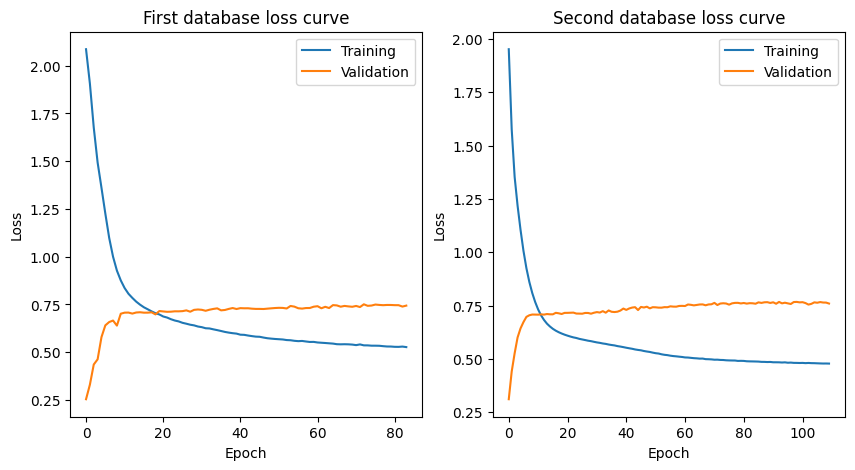

In [44]:
display_model_statistics(first_mlp1, second_mlp1)
plot_loss_curve(first_mlp1, second_mlp1)


Wyniki dla obu baz danych są do siebie zbliżone, jednak krzywe uczenia się wskazują na przeuczenie modeli (overfitting).


### Drugi model


Parametry dla drugiego modelu są następujące:

- optymalizator uczenia się (`solver`) - Adam
- wielkość warstwy ukrytej (`hidden_layer_size`) - jedna warstwa ukryta z $10$ neuronami
- funkcja aktywacji (`activation`) - relu

Pozostałe parametry są pozostają niezmienione dla wszystkich modeli.


In [45]:
mlp2_params = {
    "solver": "adam", "hidden_layer_sizes": (10), "activation": "relu",
    "validation_fraction": 0.2, "max_iter": 500, "early_stopping": True
}


Poniżej zostaje stworzony i nauczony pierwszy model:


In [46]:
first_mlp2 = MLPClassifier(**mlp2_params)
first_mlp2.fit(first_db_train_inputs, first_db_train_classes);


Następnie ten sam proces jest powtarzany dla drugiej bazy danych:


In [47]:
second_mlp2 = MLPClassifier(**mlp2_params)
second_mlp2.fit(second_db_train_inputs, second_db_train_classes);


Poniżej wyświetlone są wyniki klasyfikatorów:


First database acuraccy: 71.618%			Second database acuraccy: 72.561%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2097,6,0,0,0,0,0,0
1,4,1762,269,0,0,1,0,0
2,1,668,1022,333,1,0,0,0
3,0,0,498,1199,166,67,1,0
4,0,0,0,92,1176,744,0,0
5,0,0,0,5,376,909,712,0
6,0,0,0,0,0,201,1385,411
7,0,0,0,0,0,0,35,2035
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


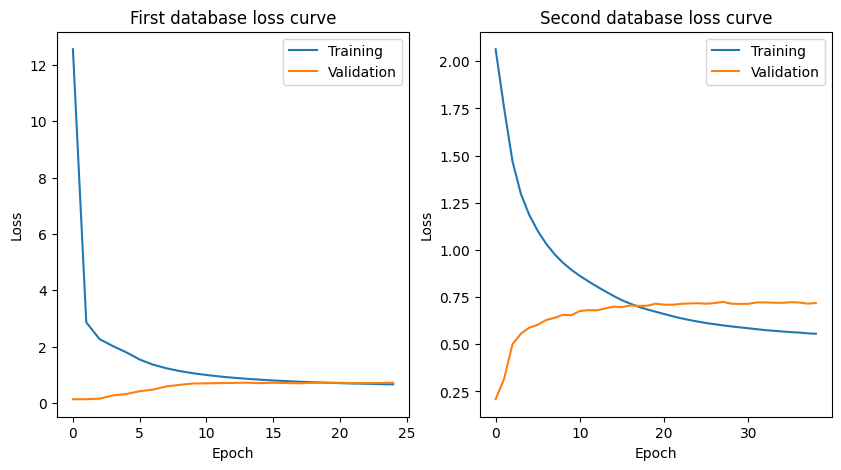

In [48]:
display_model_statistics(first_mlp2, second_mlp2)
plot_loss_curve(first_mlp2, second_mlp2)


Wyniki dla obu baz są do siebie bardzo podobne, jednak dla mniej przetworzonych danych sieć jest o wiele lepiej nauczona (good fit), podczas gdy dla drugiego zestawu danych sieć jest przeuczona (overfitted).


### Trzeci model


Poniżej opisane są parametry dla trzeciego modelu:

- optymalizator uczenia się (`solver`) - sgd
- wielkość warstwy ukrytej (`hidden_layer_size`) - cztery warstwy ukryte zawierające kolejno $5$, $4$, $3$ i $2$ neurony
- funkcja aktywacji (`activation`) - identity


In [49]:
mlp3_params = {
    "solver": "sgd", "hidden_layer_sizes": (5, 4, 3, 2), "activation": "identity",
    "validation_fraction": 0.2, "max_iter": 500, "early_stopping": True
}


Po zdefiniowaniu parametrów tworzona i uczona jest pierwsza sieć:


In [50]:
first_mlp3 = MLPClassifier(**mlp3_params)
first_mlp3.fit(first_db_train_inputs, first_db_train_classes);


Następnie na postawie drugiej bazy danych uczona jest nowa sieć:


In [51]:
second_mlp3 = MLPClassifier(**mlp3_params)
second_mlp3.fit(second_db_train_inputs, second_db_train_classes);


Poniżej zostaje wyświetlone porównaniu obu klasyfikacji:


First database acuraccy: 70.988%			Second database acuraccy: 70.760%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2103,0,0,0,0,0,0,0
1,5,2031,0,0,0,0,0,0
2,0,929,404,692,0,0,0,0
3,0,0,344,1348,238,1,0,0
4,0,0,0,0,2012,0,0,0
5,0,0,0,0,1096,8,898,0
6,1,0,0,0,0,1,1600,395
7,0,0,0,0,0,0,93,1977
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


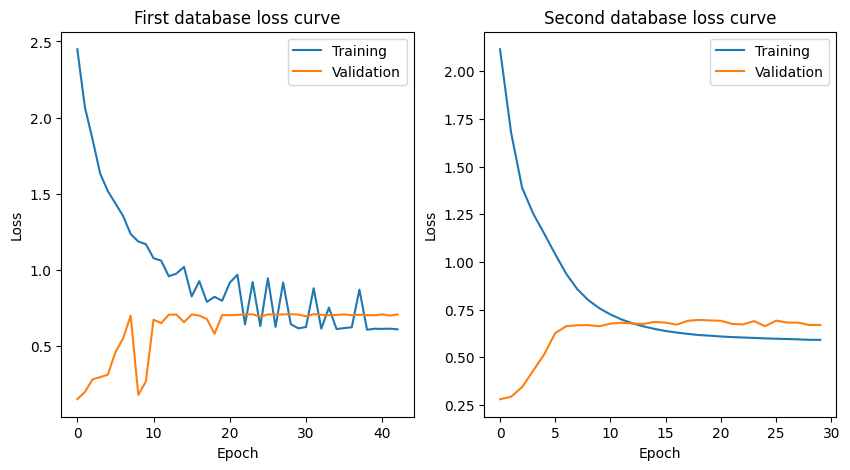

In [52]:
display_model_statistics(first_mlp3, second_mlp3)
plot_loss_curve(first_mlp3, second_mlp3)


Ponownie wyniki są do siebie mocno zbliżone, jednak z wykresu widać, że dla mniej przetworzonych danych sieć jest nauczona gorzej niż w przypadku drugiego zestawu danych.


### Czwarty model


Dla czwartego modelu zdefiniowane są poniższe własności:

- optymalizator uczenia się (`solver`) - Adam
- wielkość warstwy ukrytej (`hidden_layer_size`) - trzy warstwy ukryte z odpowiednio $15$, $10$ i $5$ neuronami
- funkcja aktywacji (`activation`) - logistic


In [53]:
mlp4_params = {
    "solver": "adam", "hidden_layer_sizes": (15, 10, 5), "activation": "logistic",
    "validation_fraction": 0.2, "max_iter": 500, "early_stopping": True
}


Poniżej tworzone i uczone są sieci dla obu zestawów danych, a następnie wyświetlone jest ich porównanie:


In [54]:
first_mlp4 = MLPClassifier(**mlp4_params)
first_mlp4.fit(first_db_train_inputs, first_db_train_classes);


In [55]:
second_mlp4 = MLPClassifier(**mlp4_params)
second_mlp4.fit(second_db_train_inputs, second_db_train_classes);


First database acuraccy: 75.624%			Second database acuraccy: 73.240%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2101,2,0,0,0,0,0,0
1,4,1842,190,0,0,0,0,0
2,0,637,933,455,0,0,0,0
3,0,0,400,1292,230,9,0,0
4,0,0,0,1,1720,291,0,0
5,0,0,0,0,459,752,791,0
6,0,0,0,1,0,44,1528,424
7,0,0,0,0,0,0,5,2065
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


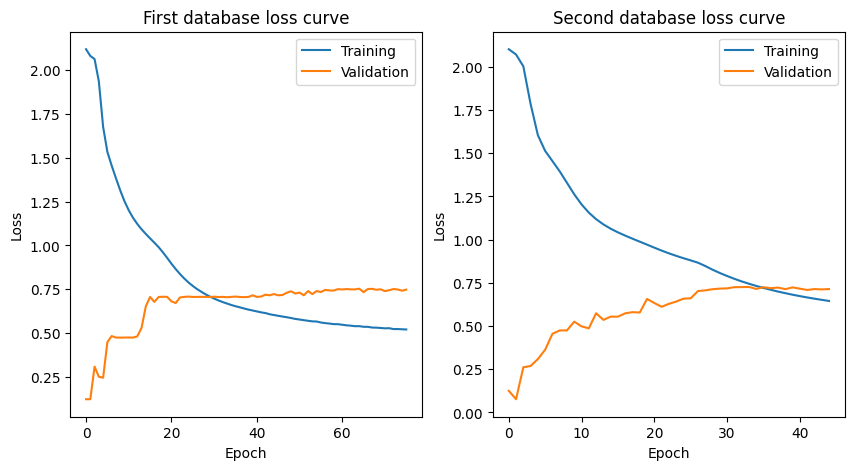

In [56]:
display_model_statistics(first_mlp4, second_mlp4)
plot_loss_curve(first_mlp4, second_mlp4)


W tym przypadku również widać, że dla bardziej przetworzonych danych sieć jest lepiej nauczona.


### Piąty model


Ostatni model zostanie zdefiniowany z poniższymi parametrami:

- optymalizator uczenia się (`solver`) - Adam
- wielkość warstwy ukrytej (`hidden_layer_size`) - cztery warstwy ukryte z odpowiednio $10$, $15$, $10$ i $5$ neuronami
- funkcja aktywacji (`activation`) - relu


In [57]:
mlp5_params = {
    "solver": "adam", "hidden_layer_sizes": (10, 15, 10, 5), "activation": "relu",
    "validation_fraction": 0.2, "max_iter": 500, "early_stopping": True
}


Najpierw tworzona i uczona jest sieć dla pierwszego zestawu danych:

In [58]:
first_mlp5 = MLPClassifier(**mlp5_params)
first_mlp5.fit(first_db_train_inputs, first_db_train_classes);


Następnie przeprowadzana jest nauka drugiej sieci przy pomoce drugiej bazy danych:

In [59]:
second_mlp5 = MLPClassifier(**mlp5_params)
second_mlp5.fit(second_db_train_inputs, second_db_train_classes);


Po wytrenowaniu sieci prezentowane są ich wyniki:

First database acuraccy: 71.600%			Second database acuraccy: 76.031%
First database confusion matrix:			Second database confusion matrix:


,0,1,2,3,4,5,6,7
0,2103,0,0,0,0,0,0,0
1,4,1951,80,0,0,0,0,1
2,0,823,540,661,1,0,0,0
3,0,0,275,1417,191,48,0,0
4,0,0,0,1,1422,589,0,0
5,0,0,0,0,558,722,722,0
6,0,0,0,0,0,190,1383,424
7,0,0,0,0,0,0,26,2044
,0,1,2,3,4,5,6,7
0,2067,0,0,0,0,0,0,0


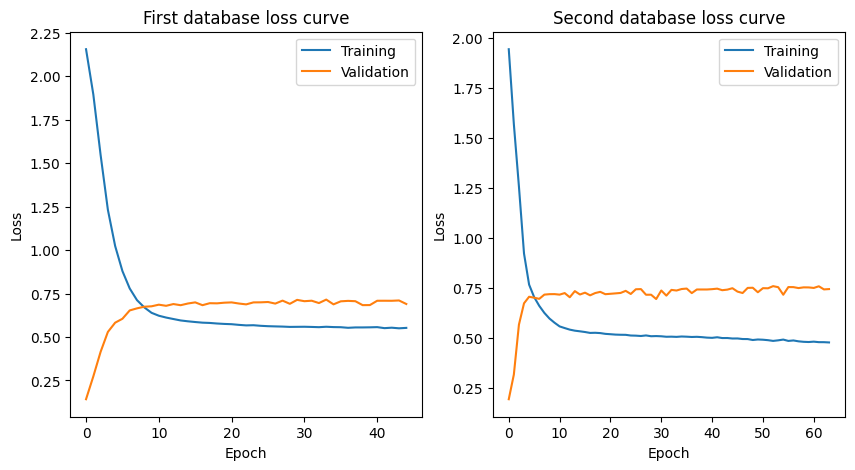

In [60]:
display_model_statistics(first_mlp5, second_mlp5)
plot_loss_curve(first_mlp5, second_mlp5)


Oba modele osiągnęły zbliżone rezultaty pod względem dokładności.
Każdy z nich jest także nieznacznie przeuczony (overfitted).

# Podsumowanie


W poniższej tabeli znajduje się podsumowanie wyników dla wszystkich klasyfikatorów:

<table><thead><tr><th rowspan="2">Klasyfikator</th><th colspan="2">Drzewo<br>decyzyjne<br></th><th rowspan="2">Naiwny<br>Bayes<br></th><th colspan="3">K-najbliższych<br>sąsiadów<br></th><th colspan="5">Sieć neuronowa</th></tr><tr><th>Większe<br></th><th>Mniejsze</th><th>k=10</th><th>k=20</th><th>k=30</th><th>#1</th><th>#2</th><th>#3</th><th>#4</th><th>#5</th></tr></thead><tbody><tr><td>Pierwsza baza<br>danych </td><td>79.000%</td><td>78.400%</td><td>69.838%</td><td>77.219%</td><td>77.127%</td><td>76.861%</td><td>75.049%</td><td>71.618%</td><td>70.988%</td><td>75.624%</td><td>71.600%</td></tr><tr><td>Druga baza <br>danych<br></td><td>79.056%</td><td>78.301%</td><td>69.891%</td><td>80.325%</td><td>80.623%</td><td>80.534%</td><td>76.887%</td><td>72.561%</td><td>70.760%</td><td>73.240%</td><td>76.031%</td></tr></tbody></table>

Jak widać wszystkie klasyfikatory osiągały dość zbliżone rezultaty, wahające się od $69.9\%$ dla naiwnego klasyfikatora bayesowskiego do $80.6\%$ dla 20-najbliższych sąsiadów. 
Główne różnice między mniej i bardziej przetworzonymi danymi były widoczne przy klasyfikatorach K-najbliższych sąsiadów, gdzie różnica w każdym przypadku wyniosła około $3\%$ na korzyść drugiej bazy danych, oraz w sieciach neuronowych, gdzie dla modelu pierwszego, drugiego oraz trzeciego również lepsza okazała się bardziej przetworzona baza.
# Bibliografia

- [dokumentacja Pandas](https://pandas.pydata.org/)
- [dokumentacja NumPy](https://numpy.org/)
- [dokumentacja SciPy](https://scipy.org/)
- [dokumentacja scikit-learn](https://scikit-learn.org/stable/)
- [Drzewa decyzyjne (Wikipedia)](https://pl.wikipedia.org/wiki/Drzewo_decyzyjne)
- [Naiwny klasyfikator bayesowski (Wikipedia)](https://pl.wikipedia.org/wiki/Naiwny_klasyfikator_bayesowski)
- [K-najbliższych sąsiadów (Wikipedia)](https://pl.wikipedia.org/wiki/K_najbli%C5%BCszych_s%C4%85siad%C3%B3w)
- [Sieci neuronowe (Wikipedia)](https://pl.wikipedia.org/wiki/Sie%C4%87_neuronowa)
- [Odczytywanie danych z krzywej uczenia się](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)